# Molecular Property Prediction with AttentiveFP
Using PyTorch Geometric's implementation of AttentiveFP for molecular property prediction.


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import AttentiveFP
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


# Data Preparation
Create a PyTorch Geometric dataset from SMILES strings.


In [40]:
class MoleculeDataset(Dataset):
    def __init__(self, df, smiles_col='smiles', target_col='active'):
        super().__init__()
        self.df = df
        self.smiles_col = smiles_col
        self.target_col = target_col
        self.data_list = self._prepare_data()
        
    def _prepare_data(self):
        data_list = []
        for idx, row in self.df.iterrows():
            mol = Chem.MolFromSmiles(row[self.smiles_col])
            if mol is None:
                continue
                
            # Get node features
            num_atoms = mol.GetNumAtoms()
            atom_features = []
            for atom in mol.GetAtoms():
                atom_features.append([
                    atom.GetAtomicNum(),
                    atom.GetDegree(),
                    atom.GetFormalCharge(),
                    atom.GetNumRadicalElectrons(),
                    atom.GetHybridization(),
                    atom.GetIsAromatic(),
                    atom.GetTotalNumHs()
                ])
            x = torch.tensor(atom_features, dtype=torch.float)
            
            # Get edge indices and features
            edges_list = []
            edge_features = []
            for bond in mol.GetBonds():
                i = bond.GetBeginAtomIdx()
                j = bond.GetEndAtomIdx()
                edges_list.extend([[i, j], [j, i]])
                
                # Bond features
                bond_type = bond.GetBondType()
                features = [
                    bond_type == Chem.rdchem.BondType.SINGLE,
                    bond_type == Chem.rdchem.BondType.DOUBLE,
                    bond_type == Chem.rdchem.BondType.TRIPLE,
                    bond_type == Chem.rdchem.BondType.AROMATIC,
                    bond.GetIsConjugated(),
                ]
                edge_features.extend([features, features])
                
            edge_index = torch.tensor(edges_list, dtype=torch.long).t()
            edge_attr = torch.tensor(edge_features, dtype=torch.float)
            
            # Create PyG Data object
            data = Data(
                x=x,
                edge_index=edge_index,
                edge_attr=edge_attr,
                y=torch.tensor([row[self.target_col]], dtype=torch.float),
            )
            data_list.append(data)
        return data_list
    
    def len(self):
        return len(self.data_list)
    
    def get(self, idx):
        return self.data_list[idx]


In [41]:
# Load data
model_name = 'Irritation_Corrosion_Eye_Irritation'
df = pd.read_csv(f"../data/{model_name}.csv")

# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['active'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['active'])

# Create datasets
train_dataset = MoleculeDataset(train_df)
val_dataset = MoleculeDataset(val_df)
test_dataset = MoleculeDataset(test_df)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")


Train size: 3280
Validation size: 820
Test size: 1025


# Model Definition
Using PyTorch Geometric's AttentiveFP implementation


In [42]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model
model = AttentiveFP(
    in_channels=7,  # Number of atom features
    hidden_channels=64,
    out_channels=1,  # Binary classification
    edge_dim=5,  # Number of bond features
    num_layers=3,
    num_timesteps=2,
    dropout=0.1
).to(device)

# Loss function with class weights
pos_weight = torch.tensor([
    (len(train_df) - train_df['active'].sum()) / train_df['active'].sum()
]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)


# Training and Evaluation Functions


In [43]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    predictions = []
    targets = []
    
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        out = model(
            batch.x, batch.edge_index, batch.edge_attr, batch.batch
        )
        
        target = batch.y
        
        loss = criterion(out.squeeze(-1), target)  # Now shapes will match
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch.num_graphs
        predictions.extend(out.detach().cpu().numpy())
        targets.extend(batch.y.cpu().numpy())
    
    return (
        total_loss / len(loader.dataset),
        np.array(predictions),
        np.array(targets)
    )

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(
                batch.x, batch.edge_index, batch.edge_attr,
                batch=batch.batch
            )
            loss = criterion(out.squeeze(-1), batch.y)
            
            total_loss += loss.item() * batch.num_graphs
            predictions.extend(torch.sigmoid(out).cpu().numpy())
            targets.extend(batch.y.cpu().numpy())
    
    predictions = np.array(predictions)
    targets = np.array(targets)
    
    return {
        'loss': total_loss / len(loader.dataset),
        'accuracy': accuracy_score(targets, predictions > 0.5),
        'precision': precision_score(targets, predictions > 0.5),
        'recall': recall_score(targets, predictions > 0.5),
        'f1': f1_score(targets, predictions > 0.5),
        'auc': roc_auc_score(targets, predictions)
    }


# Training Loop


In [44]:
num_epochs = 50
best_val_loss = float('inf')
patience = 10
patience_counter = 0
history = {
    'train_loss': [], 'val_loss': [],
    'val_accuracy': [], 'val_f1': [], 'val_auc': []
}

for epoch in range(num_epochs):
    # Training
    train_loss, train_preds, train_targets = train_epoch(
        model, train_loader, optimizer, criterion, device
    )
    
    # Validation
    val_metrics = evaluate(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_metrics['loss'])
    
    # Save metrics
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_metrics['loss'])
    history['val_accuracy'].append(val_metrics['accuracy'])
    history['val_f1'].append(val_metrics['f1'])
    history['val_auc'].append(val_metrics['auc'])
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_metrics['loss']:.4f}")
    print(f"Val Metrics: Acc={val_metrics['accuracy']:.3f}, "
          f"F1={val_metrics['f1']:.3f}, AUC={val_metrics['auc']:.3f}")
    
    # Early stopping
    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        patience_counter = 0
        torch.save(model.state_dict(), f"../models/model_{model_name}_geometric.pt")
        print("✓ Saved best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
    print("-" * 50)


Epoch 1/50
Train Loss: 0.2129
Val Loss: 0.2103
Val Metrics: Acc=0.828, F1=0.878, AUC=0.892
✓ Saved best model
--------------------------------------------------
Epoch 2/50
Train Loss: 0.1890
Val Loss: 0.1937
Val Metrics: Acc=0.861, F1=0.905, AUC=0.911
✓ Saved best model
--------------------------------------------------
Epoch 3/50
Train Loss: 0.1777
Val Loss: 0.1949
Val Metrics: Acc=0.828, F1=0.876, AUC=0.915
--------------------------------------------------
Epoch 4/50
Train Loss: 0.1601
Val Loss: 0.1657
Val Metrics: Acc=0.866, F1=0.906, AUC=0.935
✓ Saved best model
--------------------------------------------------
Epoch 5/50
Train Loss: 0.1546
Val Loss: 0.1584
Val Metrics: Acc=0.870, F1=0.909, AUC=0.939
✓ Saved best model
--------------------------------------------------
Epoch 6/50
Train Loss: 0.1463
Val Loss: 0.1606
Val Metrics: Acc=0.889, F1=0.924, AUC=0.937
--------------------------------------------------
Epoch 7/50
Train Loss: 0.1460
Val Loss: 0.1567
Val Metrics: Acc=0.902, F

# Evaluation and Visualization


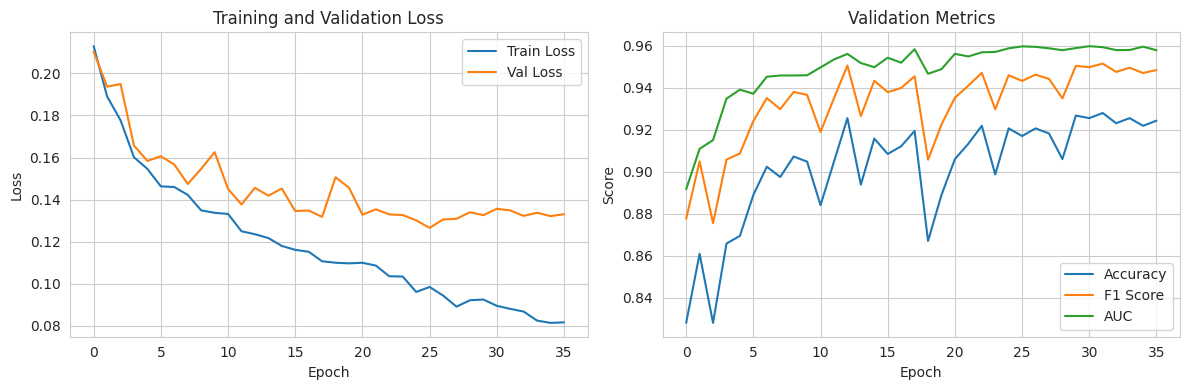


Test Set Metrics:
loss: 0.1497
accuracy: 0.9132
precision: 0.9544
recall: 0.9282
f1: 0.9411
auc: 0.9464


In [45]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_accuracy'], label='Accuracy')
plt.plot(history['val_f1'], label='F1 Score')
plt.plot(history['val_auc'], label='AUC')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

# Final evaluation on test set
model.load_state_dict(torch.load(f"../models/model_{model_name}_geometric.pt"))
test_metrics = evaluate(model, test_loader, criterion, device)

print("\nTest Set Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")